Paper:
https://arxiv.org/pdf/1512.04150.pdf

GitHub:
https://github.com/jacobgil/keras-cam

In [1]:
import glob
import os, sys
import numpy as np
import scipy

import cv2
import skimage
import matplotlib.pyplot as plt
from keras.preprocessing import image as kimage

%matplotlib inline
sys.path.insert(0,'..') # add parent directory to path

import keras
from keras.utils.np_utils import to_categorical
import h5py

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.models import *
from keras.callbacks import *
import keras.backend as K

from sklearn.model_selection import train_test_split

import utils
import core_models
import poet_file_manager

Using TensorFlow backend.


In [2]:
img_width = 224
img_size = (img_width, img_width)
img_shape = (img_width, img_width, 3)

In [3]:
train_ids, test_ids = utils.load_object('../train_ids.pkl'), utils.load_object('../test_ids.pkl')

In [4]:
def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))

def global_average_pooling_shape(input_shape):
    return input_shape[2:4]

def get_model(out_classes, img_shape, mode='vgg'):
    
    if mode=='vgg':
        model = core_models.VGG16_convolutions(img_shape=img_shape)
        model = load_model_weights(model, "./vgg.h5")

    #     model = resnet()
        for layer in model.layers[:]:
            layer.trainable = False
    
    if mode=='other':
        model = core_models.other_model(img_shape)
        
    # Rename last conv layer to later access it for CAM
    model.layers[-1].name = 'last_conv'
    
    # There cannot be any other layer in between the Dense and Global Average Pooling
    # due to how class activations are generated
    model.add(Lambda(global_average_pooling, 
              output_shape=global_average_pooling_shape))
    model.add(Dense(out_classes, activation = 'softmax'))

    optm = Adam()
    model.compile(loss = 'categorical_crossentropy', optimizer = optm, metrics=['accuracy'])
    
    print(model.summary())
    for layer in model.layers:
        print(layer.name, layer.trainable)
    return model

def load_model_weights(model, weights_path):
    print('Loading model.')

    model.load_weights(weights_path)

    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [30]:
def visualize_class_activation_map(model_path, original_img, output_path, class_map, 
                                   visualize_for_class=None, cam_thresh=0.4):
    # adapted from https://github.com/jacobgil/keras-cam
    # visualize_for_class_n decides for which class the CAM should be plotted
    inv_class_map = {value: key for key, value in class_map.items()}
    
    model = load_model(model_path)
    width, height, _ = original_img.shape

    img = np.array([np.float32(original_img)])

    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "last_conv")
    
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    proba_res = [(i, proba) for i, proba in enumerate(predictions[0])]
    proba_res.sort(key= lambda pair: pair[1], reverse=True)
#     print(proba_res)
    for i, proba in enumerate(proba_res):
        print(inv_class_map[proba[0]], proba[1])
    
    conv_outputs = conv_outputs[0, :, :, :]
#     print('class weights:', class_weights.shape)
    
    if type(visualize_for_class) == str:
        visualize_for_class = class_map[visualize_for_class]
    
    # visualize the maximum prob class if no class was specified in arguments
    if visualize_for_class is None:
        class_n = np.argmax(predictions)
    else:
        class_n = visualize_for_class
        
    print("Visualizing for", inv_class_map[class_n])
    print("Prediction", inv_class_map[np.argmax(predictions)])

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_n]):
        cam += w * conv_outputs[:, :, i]
    
    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < cam_thresh)] = 0
    
    img = (heatmap*0.5 + original_img)
    img /= np.max(img)
    
    plt.imshow(img)
    return cam, original_img
#     cv2.imwrite(output_path, img)
#     cv2.imshow('test', img)

In [6]:
train_0 = [el.split('/')[-1] for el in glob.glob('./train/0/*')]
test_0 = [el.split('/')[-1] for el in glob.glob('./test/0/*')]

In [7]:
len(train_0), len(test_0)

(599, 67)

In [8]:
test_0[0] in train_0

False

In [9]:
epochs_n = 200
batch_size = 32

if not os.path.exists('./weights'):
    os.makedirs('./weights')
checkpoint_path="./weights/vggweights.{epoch:02d}-{val_loss:.2f}.hdf5"

train_data_dir = './train/'
test_data_dir = './test/'

train_datagen = ImageDataGenerator(
                                   horizontal_flip=False
                                )

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

X_test, y_test, class_map, names = poet_file_manager.load_poet(img_size, test_ids)

Found 5517 images belonging to 10 classes.
Loading POET dataset...
aeroplane* 0
boat* 1
dog* 2
bicycle* 3
cat* 4
cow* 5
diningtable* 6
horse* 7
motorbike* 8
sofa* 9
X.shape: (614, 224, 224, 3) y.shape: (614,)
Loaded POET dataset.


In [10]:
model = get_model(out_classes=10, img_shape=img_shape, mode='vgg')

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
  model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
  mod

Loading model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856 

In [11]:
print("Training..")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

history = model.fit_generator(train_generator, epochs=epochs_n, callbacks=[checkpoint], validation_data=(X_test, y_test),
                             steps_per_epoch = len(train_generator.filenames) / batch_size)

Training..
Epoch 1/200
173/172 [==============================] - 29s 166ms/step - loss: 2.2367 - acc: 0.5057 - val_loss: 1.2681 - val_acc: 0.6384
Epoch 2/200
173/172 [==============================] - 27s 154ms/step - loss: 0.9878 - acc: 0.7178 - val_loss: 0.9843 - val_acc: 0.6938
Epoch 3/200
173/172 [==============================] - 27s 154ms/step - loss: 0.7400 - acc: 0.7707 - val_loss: 0.8099 - val_acc: 0.7524
Epoch 4/200
173/172 [==============================] - 27s 154ms/step - loss: 0.6175 - acc: 0.7989 - val_loss: 0.7332 - val_acc: 0.7687
Epoch 5/200
173/172 [==============================] - 27s 154ms/step - loss: 0.5307 - acc: 0.8215 - val_loss: 0.7430 - val_acc: 0.7818
Epoch 6/200
173/172 [==============================] - 27s 154ms/step - loss: 0.4714 - acc: 0.8461 - val_loss: 0.7134 - val_acc: 0.7769
Epoch 7/200
173/172 [==============================] - 27s 154ms/step - loss: 0.4188 - acc: 0.8595 - val_loss: 0.6861 - val_acc: 0.7915
Epoch 8/200
173/172 [================

KeyboardInterrupt: 

In [16]:
inv_class_map = inv_map = {v: k for k, v in class_map.items()}
model_path = './weights/vggweights.09-0.67.hdf5'

In [17]:
model = load_model(model_path)
y_pred = model.predict(X_test)

In [18]:
np.mean(np.argmax(y_test, 1) == np.argmax(y_pred, 1))

0.7850162866449512

Normalized confusion matrix


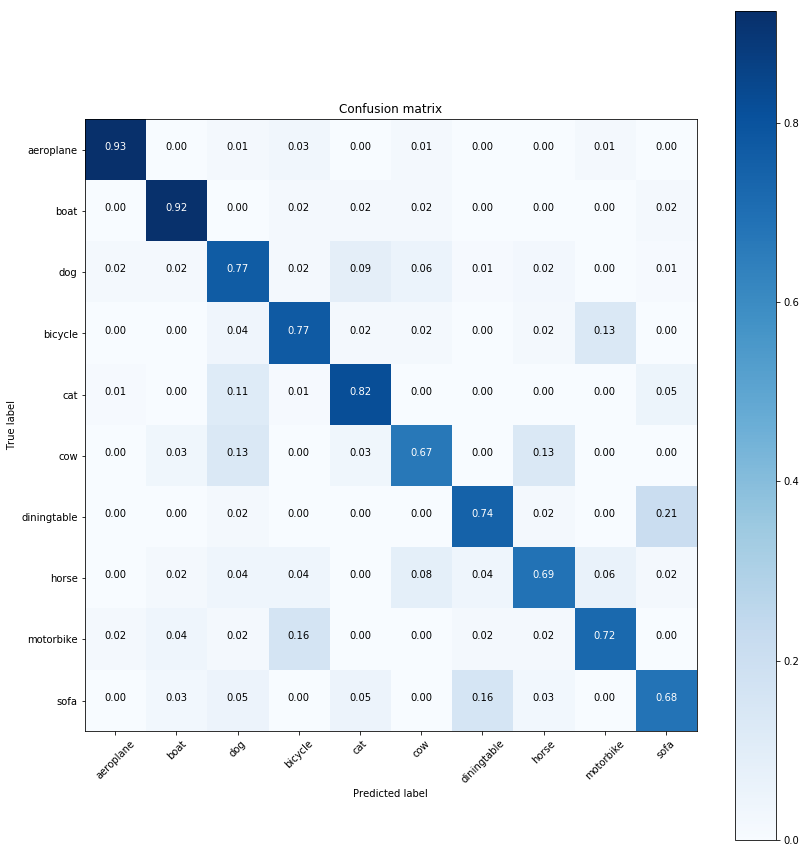

In [19]:
plt.figure(figsize=(12,12))
fig = utils.plot_confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1), class_map.keys(), normalize=True)

In [20]:
mistakes_mask = np.argmax(y_test, 1) != np.argmax(y_pred, 1)
mistakes_names = names[mistakes_mask]

In [21]:
name = 'dog_2010_005149.jpg'
name = mistakes_names[0]

In [22]:
def get_class(images, cat_labels, class_name):
    class_mask = np.argmax(cat_labels, 1) == class_map[class_name]
    return images[class_mask]

def get_image(images, file_names, image_name):
    index = list(file_names).index(image_name)
    return images[index]

cow 0.92132735
aeroplane 0.05244623
horse 0.016998628
dog 0.008176808
sofa 0.0006318101
boat 0.0001799004
motorbike 0.000115031005
bicycle 0.000105623236
cat 1.837644e-05
diningtable 2.6791727e-07
Visualizing for cow
Prediction cow
cow


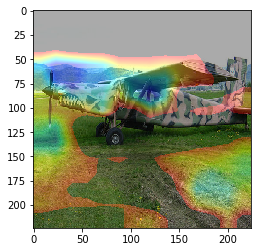

In [32]:
heatmap, org_img = visualize_class_activation_map(model_path=model_path, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.1)

cow 0.9598912
dog 0.038116906
cat 0.0019165644
horse 5.8952483e-05
bicycle 1.0122746e-05
aeroplane 4.0179307e-06
sofa 5.944959e-07
boat 5.451188e-07
diningtable 5.1162357e-07
motorbike 5.0569867e-07
Visualizing for cow
Prediction cow
cow


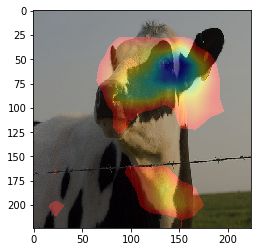

In [34]:
heatmap, org_img = visualize_class_activation_map(model_path=model_path, 
                                   original_img=get_class(X_test, y_test, 'cow')[10], 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.1)

aeroplane_2008_004348.jpg
cow 0.92132735
aeroplane 0.05244623
horse 0.016998628
dog 0.008176808
sofa 0.0006318101
boat 0.0001799004
motorbike 0.000115031005
bicycle 0.000105623236
cat 1.837644e-05
diningtable 2.6791727e-07
Visualizing for cow
Prediction cow
cow


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


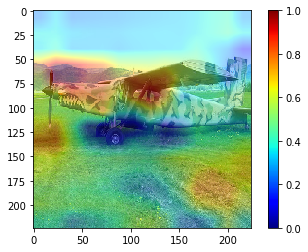

In [36]:
def construct_name(class_name, file_id):
    return class_name + '_' + str(file_id) + '.jpg'

file_tuple = ('dog','2008_000078')

print(name)
heatmap, org_img = visualize_class_activation_map(model_path=model_path, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', class_map=class_map, 
                                   visualize_for_class='cow', cam_thresh=0.1)

def overlay_heatmap(org_img, heatmap):
    img = org_img/255
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.6

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img

plt.imshow(overlay_heatmap(org_img, heatmap), cmap='jet')
plt.colorbar()